In [1]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.144:40867,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
print(client)

<Client: 'tcp://10.0.128.144:40867' processes=0 threads=0, memory=0 B>


In [5]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


### Load functions

In [8]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [9]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [10]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def makeROMSGridObject(ds,rename=True):
    if rename==True:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds, grid

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics={
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [11]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

def calc_depthAverageROMS2(input,dx,dz0,etaTransect):
    input = input.isel(eta_rho=etaTransect)
    dz = dz0.isel(eta_rho=etaTransect)
    dx = dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [12]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [13]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

# time_range_to_load_S = slice('2012-01-01','2012-06-01')
# time_range_to_load_N = slice('2012-06-01','2012-11-01')

time_range_to_load_S = slice('2012-04-20','2012-04-21')
time_range_to_load_N = slice('2012-03-06','2012-03-07')
time_range_to_load_eddyN = slice('2012-06-29','2012-07-09')
time_range_to_load_eddy1 = slice('2012-03-06','2012-03-12')
time_range_to_load_eddy2 = slice('2012-07-29','2012-08-08')
time_range_to_load_eddy3 = slice('2012-03-11','2012-03-16')


range_S = (str(time_range_to_load_S.start)+' - '+str(time_range_to_load_S.stop))
range_N = (str(time_range_to_load_N.start)+' - '+str(time_range_to_load_N.stop))
range_eddyN = (str(time_range_to_load_eddyN.start)+' - '+str(time_range_to_load_eddyN.stop))
range_eddy1 = (str(time_range_to_load_eddy1.start)+' - '+str(time_range_to_load_eddy1.stop))
range_eddy2 = (str(time_range_to_load_eddy2.start)+' - '+str(time_range_to_load_eddy2.stop))
range_eddy3 = (str(time_range_to_load_eddy3.start)+' - '+str(time_range_to_load_eddy3.stop))

In [14]:
# Load zeta data
VarToKeep = ['z_rho0','temp','dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
truth = truth.drop('z_rho')
truth["dz0"] = truth_bu.dz.mean(dim='ocean_time')
truth["dz_w0"]=truth_bu.dz_w.mean(dim='ocean_time')
truth["dx"] = truth_bu.dx
truth["z_rho0"] = truth.z_rho0.fillna(0)
truth["z_w0"]=truth_bu.z_w.mean(dim='ocean_time').fillna(0)
# truth["s_w"] = truth_bu.s_w
# truth["s_w3"],dump = xr.broadcast(truth.s_w,truth.lon_rho)

OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)

#load grid file
grid = makeROMSGridObject(OSSE_SSHSST)

OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

OSSE_SSHSST["z_rho0"] = OSSE_SSHSST.z_rho0.fillna(0)
OSSE_SSHSST_XBT["z_rho0"] = OSSE_SSHSST_XBT.z_rho0.fillna(0)
OSSE_SSHSST_XBT_N["z_rho0"] = OSSE_SSHSST_XBT_N.z_rho0.fillna(0)
OSSE_SSHSST_XBT_S["z_rho0"] = OSSE_SSHSST_XBT_S.z_rho0.fillna(0)

OSSE_SSHSST["z_w0"]=OSSE_SSHSST_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT["z_w0"]=OSSE_SSHSST_XBT_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT_N["z_w0"]=OSSE_SSHSST_XBT_N_bu.z_w.mean(dim='ocean_time').fillna(0)
OSSE_SSHSST_XBT_S["z_w0"]=OSSE_SSHSST_XBT_S_bu.z_w.mean(dim='ocean_time').fillna(0)


OSSE_SSHSST["dx"] = OSSE_SSHSST_bu.dx
OSSE_SSHSST_XBT["dx"] = OSSE_SSHSST_XBT_bu.dx
OSSE_SSHSST_XBT_N["dx"] = OSSE_SSHSST_XBT_N_bu.dx
OSSE_SSHSST_XBT_S["dx"] = OSSE_SSHSST_XBT_S_bu.dx

OSSE_SSHSST["dz0"] = OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz0"] = OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz0"] = OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz0"] = OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')

OSSE_SSHSST["dz_w0"]=OSSE_SSHSST_bu.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT["dz_w0"]=OSSE_SSHSST_XBT_bu.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N["dz_w0"]=OSSE_SSHSST_XBT_N_bu.dz_w.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S["dz_w0"]=OSSE_SSHSST_XBT_S_bu.dz_w.mean(dim='ocean_time')


# OSSE_SSHSST["s_w"] = OSSE_SSHSST_bu.s_w
# OSSE_SSHSST["s_w3"],dump = xr.broadcast(OSSE_SSHSST.s_w,OSSE_SSHSST.lon_rho)
# OSSE_SSHSST_XBT["s_w"] = OSSE_SSHSST_XBT_bu.s_w
# OSSE_SSHSST_XBT["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT.s_w,OSSE_SSHSST_XBT.lon_rho)
# OSSE_SSHSST_XBT_N["s_w"] = OSSE_SSHSST_XBT_N_bu.s_w
# OSSE_SSHSST_XBT_N["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_N.s_w,OSSE_SSHSST_XBT_N.lon_rho)
# OSSE_SSHSST_XBT_S["s_w"] = OSSE_SSHSST_XBT_S_bu.s_w
# OSSE_SSHSST_XBT_S["s_w3"],dump = xr.broadcast(OSSE_SSHSST_XBT_S.s_w,OSSE_SSHSST_XBT_S.lon_rho)

truth = truth.drop(['dz','z_w0','dz0'])
OSSE_SSHSST = OSSE_SSHSST.drop(['dz','z_w0','dz0'])
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop(['dz','z_w0','dz0'])
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop(['dz','z_w0','dz0'])
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop(['dz','z_w0','dz0'])

SSHSST = OSSE_SSHSST
SSHSST_XBT_N = OSSE_SSHSST_XBT_N
SSHSST_XBT_S = OSSE_SSHSST_XBT_S
SSHSST_XBT = OSSE_SSHSST_XBT




truth.load(), print('done, loaded ~'+str(truth.nbytes/1024/1024/1024)+'G')
SSHSST.load(), print('done, loaded ~'+str(SSHSST.nbytes/1024/1024/1024)+'G')
SSHSST_XBT.load(), print('done, loaded ~'+str(SSHSST_XBT.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_N.load(), print('done, loaded ~'+str(SSHSST_XBT_N.nbytes/1024/1024/1024)+'G')
SSHSST_XBT_S.load(), print('done, loaded ~'+str(SSHSST_XBT_S.nbytes/1024/1024/1024)+'G')



done, loaded ~1.5842059627175331G
done, loaded ~1.5842059627175331G
done, loaded ~1.5842059627175331G
done, loaded ~1.5842059627175331G
done, loaded ~1.5842059627175331G


(<xarray.Dataset>
 Dimensions:     (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 80, s_w: 31)
 Coordinates:
     z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.485 -1.037
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-12-31
   * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.61
     dA          (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
     dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
     dy          (eta_rho, xi_rho) float64 5e+03 4.999e+03 ... 4.881e+03
     dz_w0       (s_w, eta_rho, xi_rho

In [15]:
# calculate isothermal slope at 250m and 500m depth

def calc_IsothermalSlopeAt250And500(input):
#     input["dTdz"] = grid.diff(input.temp,'Z',boundary='fill',fill_value=np.nan)/input.dz_w0
#     input["dTdz_rho"] = grid.interp(input.dTdz,'Z',boundary='fill')

#     input["temp250"] = horizontalSectionROMS(grid, input.temp, np.array([-250]))
#     input["temp500"] = horizontalSectionROMS(grid, input.temp, np.array([-500]))

#     input["dTdz250"] = horizontalSectionROMS(grid, input.dTdz_rho, np.array([-250]))
#     input["dTdz500"] = horizontalSectionROMS(grid, input.dTdz_rho, np.array([-500]))

#     tempo = grid.derivative(input.temp250,'X',boundary='fill',fill_value=np.nan) 
#     input["dTdx250"] = grid.interp(tempo,'X',boundary='fill',fill_value=np.nan)

#     tempo = grid.derivative(input.temp500,'X',boundary='fill',fill_value=np.nan) 
#     input["dTdx500"] = grid.interp(tempo,'X',boundary='fill',fill_value=np.nan)

#     tempo = grid.derivative(input.temp250,'Y',boundary='fill',fill_value=np.nan) 
#     input["dTdy250"] = grid.interp(tempo,'Y',boundary='fill',fill_value=np.nan)

#     tempo = grid.derivative(input.temp500,'Y',boundary='fill',fill_value=np.nan) 
#     input["dTdy500"] = grid.interp(tempo,'Y',boundary='fill',fill_value=np.nan)

    dTdz = grid.diff(input.temp,'Z',boundary='fill',fill_value=np.nan)/input.dz_w0
    input["dTdz_rho"] = grid.interp(dTdz,'Z',boundary='fill')

    temp250 = horizontalSectionROMS(grid, input.temp, np.array([-250]))
    temp500 = horizontalSectionROMS(grid, input.temp, np.array([-500]))

    dTdz250 = horizontalSectionROMS(grid, input.dTdz_rho, np.array([-250]))
    dTdz500 = horizontalSectionROMS(grid, input.dTdz_rho, np.array([-500]))

    tempo = grid.derivative(temp250,'X',boundary='fill',fill_value=np.nan) 
    dTdx250 = grid.interp(tempo,'X',boundary='fill',fill_value=np.nan)

    tempo = grid.derivative(temp500,'X',boundary='fill',fill_value=np.nan) 
    dTdx500 = grid.interp(tempo,'X',boundary='fill',fill_value=np.nan)

    tempo = grid.derivative(temp250,'Y',boundary='fill',fill_value=np.nan) 
    dTdy250 = grid.interp(tempo,'Y',boundary='fill',fill_value=np.nan)

    tempo = grid.derivative(temp500,'Y',boundary='fill',fill_value=np.nan) 
    dTdy500 = grid.interp(tempo,'Y',boundary='fill',fill_value=np.nan)

    input["s_x250"] = -dTdx250/dTdz250
    # input["s_x500"] = -dTdx500/dTdz500

    input["s_y250"] = -dTdy250/dTdz250
    # input["s_y500"] = -dTdy500/dTdz500
    input["dTdz_rho"] = -999 # try clear memory
    input["dz_w0"] = -999 # try clear memory
    input["temp250"] = temp250
        
    return input

In [16]:
truth = calc_IsothermalSlopeAt250And500(truth)
SSHSST = calc_IsothermalSlopeAt250And500(SSHSST)
SSHSST_XBT_N = calc_IsothermalSlopeAt250And500(SSHSST_XBT_N)
SSHSST_XBT_S = calc_IsothermalSlopeAt250And500(SSHSST_XBT_S)
SSHSST_XBT = calc_IsothermalSlopeAt250And500(SSHSST_XBT)

In [17]:
SSHSST_XBT_N

<xarray.Dataset>
Dimensions:     (eta_rho: 317, xi_rho: 272, s_rho: 30, ocean_time: 80, s_w: 31)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -4.49 -1.042
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-12-31
  * s_w         (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.67
    dA          (eta_rho, xi_rho) float64 1.498e+07 1.498e+07 ... 2.929e+07
    dx          (eta_rho, xi_rho) float64 2.996e+03 2.996e+03 ... 6e+03 6e+03
    dy          (eta_rho, xi_rho) float64 5e+03 4.999e+03 ... 4.881e+03
    dz_w0       int64 -999
    dTdz_rho    int64 -999
    s_x250      (ocean_time, eta_rho, xi_rho) float64 nan nan ... 0.0004066 nan
    s_y250      (ocean_time, eta_rho, xi_rho) float64 nan nan nan ... nan nan
    temp250     (ocean_time, eta_rho, xi_rho) float64 nan nan ... 17.13 17.26
Attributes: (12/39)
    file:              roms_fwd_outer1.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.1.0/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            006x008
    history:           ROMS/TOMS, Version 3.9, Sunday - October 24, 2021 -  9...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADJOINT, ADJUST_BOUNDARY, ADJUST_STFLUX, ADJUST_W...

In [18]:
# truth["dTdz"] = grid.diff(truth.temp,'Z',boundary='fill',fill_value=np.nan)/truth.dz_w0
# truth["dTdz_rho"] = grid.interp(truth.dTdz,'Z',boundary='fill')

In [19]:
# truth["temp250"] = horizontalSectionROMS(grid, truth.temp, np.array([-250]))
# truth["temp500"] = horizontalSectionROMS(grid, truth.temp, np.array([-500]))

# truth["dTdz250"] = horizontalSectionROMS(grid, truth.dTdz_rho, np.array([-250]))
# truth["dTdz500"] = horizontalSectionROMS(grid, truth.dTdz_rho, np.array([-500]))

In [20]:
# truth.temp250.median(dim='ocean_time').plot()

In [21]:
# truth["dTdx250_l"] = grid.derivative(truth.temp250,'X',boundary='fill',fill_value=np.nan) 
# # truth["dTdy"] = grid.derivative(truth.temp500,'Y',boundary='fill',fill_value=np.nan) 
# truth["dTdx250"] = grid.interp(truth.dTdx250_l,'X',boundary='fill',fill_value=np.nan)
# # truth["dTdy_rho"] = grid.interp(truth.dTdy,'Y',boundary='fill')

# truth["dTdx500_l"] = grid.derivative(truth.temp500,'X',boundary='fill',fill_value=np.nan) 
# # truth["dTdy"] = grid.derivative(truth.temp500,'Y',boundary='fill',fill_value=np.nan) 
# truth["dTdx500"] = grid.interp(truth.dTdx500_l,'X',boundary='fill',fill_value=np.nan)
# # truth["dTdy_rho"] = grid.interp(truth.dTdy,'Y',boundary='fill')

In [22]:
# truth["dTdx250"] = horizontalSectionROMS(grid, truth.dTdx_rho, np.array([-250]))
# truth["dTdx500"] = horizontalSectionROMS(grid, truth.dTdx_rho, np.array([-500]))

# truth["dTdz250"] = horizontalSectionROMS(grid, truth.dTdz_rho, np.array([-250]))
# truth["dTdz500"] = horizontalSectionROMS(grid, truth.dTdz_rho, np.array([-500]))

In [23]:
# # truth["s_x"] = -truth.dTdx_rho/truth.dTdz_rho
# # truth["s_y"] = -truth.dTdy_rho/truth.dTdz_rho

# truth["s_x250"] = -truth.dTdx250/truth.dTdz250
# truth["s_x500"] = -truth.dTdx500/truth.dTdz500

In [24]:
# truth.dTdx250.median(dim='ocean_time').plot()

In [25]:
# truth.dTdz250.median(dim='ocean_time').plot()

In [26]:
# truth2.s_x250.mean(dim='ocean_time').plot(vmin=-.003,vmax=.003,cmap="RdBu_r")

Plot the temp field with contours, then look how it compares to gradients

In [27]:
# truth.temp.isel(ocean_time=0,eta_rho=170).plot(y='z_rho0')
# truth.temp.isel(ocean_time=0,eta_rho=170).plot.contour(y='z_rho0',levels=np.arange(0,30,2),colors='k')

# plt.ylim(-1000,0)

Where contours are close together will indicate high values of dTdi: contours close in vertical, high dTdz, close in horizontal, high dTdx

In [28]:
# truth.dTdz_rho.isel(ocean_time=0,eta_rho=150).plot(y='z_rho0')
# plt.ylim(-1000,0)

High values at bottom of mixed layer/thermocline (?)

In [29]:
# truth.dTdx_rho.isel(ocean_time=0,eta_rho=150).plot()#y='z_rho0')
# # plt.ylim(-1000,0)

High values at drop in bathymetry (steep change in temp across bottom of eddy/front). Positive is dropping isotherms to the right; Negative is rising isotherms to the right. N.b. not z-grid, so error in steep bathymetry/sloping layers.

In [30]:
# truth.s_x.isel(s_rho=-2,ocean_time=0).plot(vmin=-.05,vmax=.05,cmap="RdBu_r")

In [31]:
# truth.s_x.isel(ocean_time=10).max(dim='s_rho',skipna=True).plot(vmin=-.1,vmax=.1,cmap="RdBu_r")

In [32]:
# truth.s_x.max(dim='s_rho',skipna=True).median(dim='ocean_time').plot(vmin=-.1,vmax=.1,cmap="RdBu_r")

In [33]:
# truth.s_x.median(dim='ocean_time').max(dim='s_rho',skipna=True).plot(vmin=-.1,vmax=.1,cmap="RdBu_r")

In [34]:
# truth.s_x.isel(ocean_time=10).min(dim='s_rho',skipna=True).plot(vmin=-.1,vmax=.1,cmap="RdBu_r")

In [35]:
# truth.s_x.median(dim='ocean_time').min(dim='s_rho',skipna=True).plot(vmin=-.1,vmax=.1,cmap="RdBu_r")

In [36]:
# truth.s_x.min(dim='s_rho',skipna=True).median(dim='ocean_time').plot(vmin=-.1,vmax=.1,cmap="RdBu_r")

In [37]:
# truth.dTdz_rho.isel(ocean_time=0,eta_rho=150).plot(y='z_rho0')
# plt.ylim(-1000,0)

Text(0.5, 0.94, 'Isotherm slope at 250 m')

<Figure size 432x288 with 0 Axes>

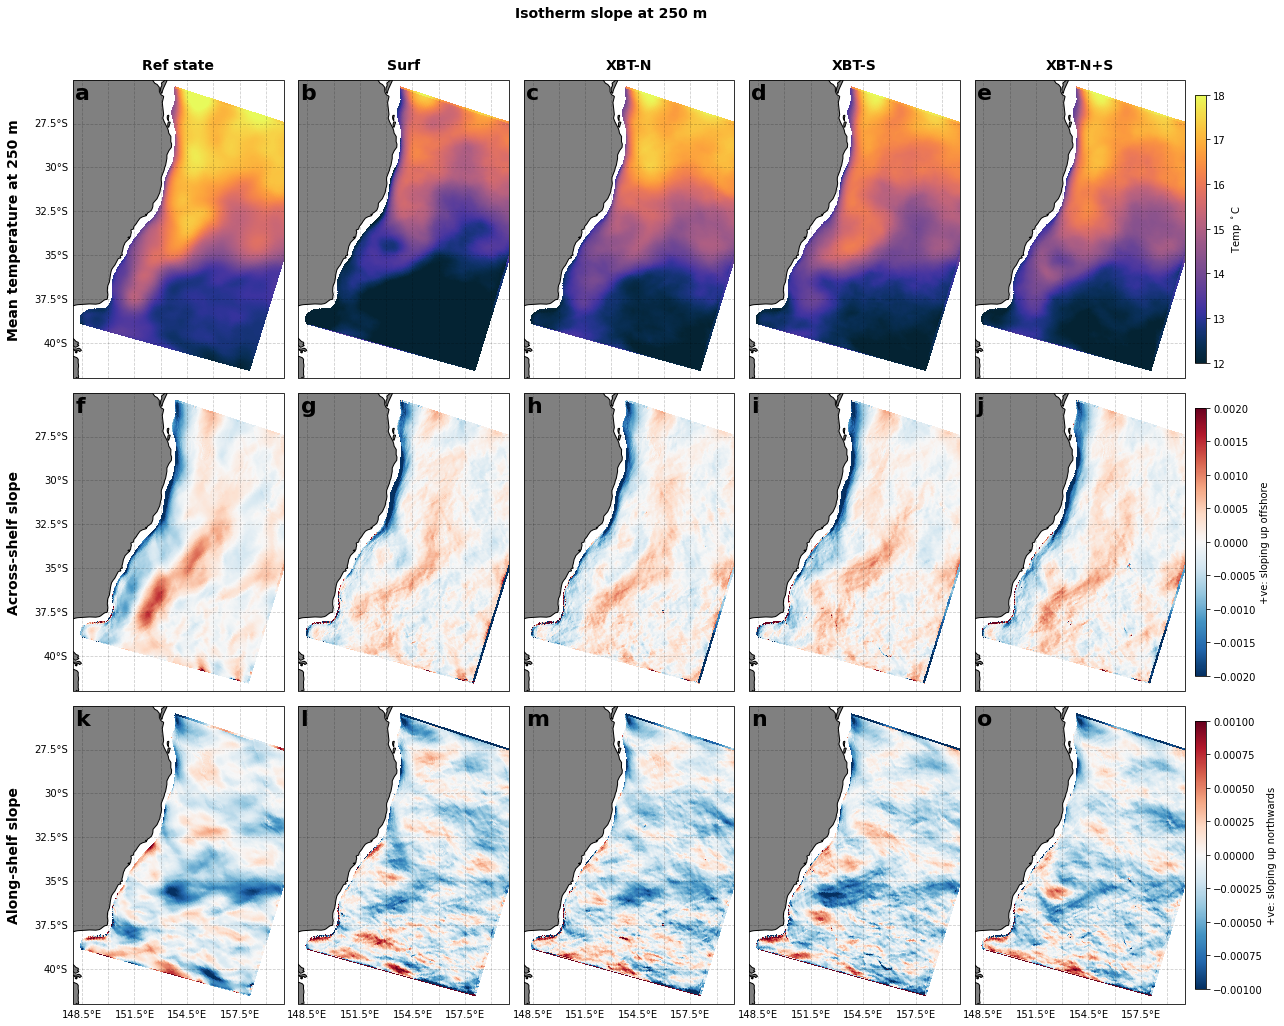

In [38]:
import cartopy.io.img_tiles as cimgt
stamen_terrain = cimgt.Stamen('terrain-background')



gs = gridspec.GridSpec(nrows=3,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,17])
ax = None


ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.temp250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.thermal",vmin=12,vmax=18)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Mean temperature at 250 m',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.temp250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.thermal",vmin=12,vmax=18)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.temp250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.thermal",vmin=12,vmax=18)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')


ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.temp250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.thermal",vmin=12,vmax=18)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.temp250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.thermal",vmin=12,vmax=18)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Temp $^\circ$C')

##

ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.s_x250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Across-shelf slope',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.s_x250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.s_x250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.s_x250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.s_x250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('+ve: sloping up offshore')


ax = fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.s_y250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Along-shelf slope',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.s_y250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'l', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.s_y250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'm', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.s_y250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'n', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.s_y250.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'o', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('+ve: sloping up northwards')

fig.suptitle('Isotherm slope at 250 m',y=.94, fontsize=14, fontweight='bold',)

Second metric: slope of a chosen isotherm

In [39]:
from scipy import interpolate
# interpolation routine for interpolating to depth where a tracer value is found
def calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims):
    depthInterp = queryfield*np.nan
    for xx in xxlims:
        for ee in eelims:
            ii = interpolate.interp1d(tempfield.isel(xi_rho=xx,eta_rho=ee),depthfield.isel(xi_rho=xx,eta_rho=ee),bounds_error=False,fill_value=np.nan)
            depthInterp[dict(eta_rho=ee,xi_rho=xx)] = ii(queryfield.isel(xi_rho=xx,eta_rho=ee))
        if xx.values in np.round(np.linspace(0,len(xxlims.values),10)):
            print(xx.values)
    return depthInterp


xxlims = truth.xi_rho.load()
eelims = truth.eta_rho.load()

isothermQueryValue = 5

tempfield = truth.temp.mean(dim='ocean_time').load() #temp field to look for isotherm
depthfield = truth.z_rho0.load() # depth field
queryfield = (truth.lon_rho*0 + 1.0*isothermQueryValue).load() # field of the query value

truth["depthIsotherm"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

tempfield = SSHSST.temp.mean(dim='ocean_time').load()
SSHSST["depthIsotherm"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

tempfield = SSHSST_XBT_N.temp.mean(dim='ocean_time').load()
SSHSST_XBT_N["depthIsotherm"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

tempfield = SSHSST_XBT_S.temp.mean(dim='ocean_time').load()
SSHSST_XBT_S["depthIsotherm"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

tempfield = SSHSST_XBT.temp.mean(dim='ocean_time').load()
SSHSST_XBT["depthIsotherm"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242
0
30
60
91
121
151
181
212
242


In [40]:
# remove land mask
truth["depthIsotherm"] = truth.depthIsotherm.where(truth.depthIsotherm!=0)
SSHSST["depthIsotherm"] = SSHSST.depthIsotherm.where(SSHSST.depthIsotherm!=0)
SSHSST_XBT_N["depthIsotherm"] = SSHSST_XBT_N.depthIsotherm.where(SSHSST_XBT_N.depthIsotherm!=0)
SSHSST_XBT_S["depthIsotherm"] = SSHSST_XBT_S.depthIsotherm.where(SSHSST_XBT_S.depthIsotherm!=0)
SSHSST_XBT["depthIsotherm"] = SSHSST_XBT.depthIsotherm.where(SSHSST_XBT.depthIsotherm!=0)

# calculate derivatives in x and y directions -> then interpolate back to rho points

truth["s_i_x"] = grid.interp(grid.derivative(truth.depthIsotherm,'X',boundary='fill',fill_value=np.nan),'X',boundary='fill',fill_value=np.nan)
truth["s_i_y"] = grid.interp(grid.derivative(truth.depthIsotherm,'Y',boundary='fill',fill_value=np.nan),'Y',boundary='fill',fill_value=np.nan)

SSHSST["s_i_x"] = grid.interp(grid.derivative(SSHSST.depthIsotherm,'X',boundary='fill',fill_value=np.nan),'X',boundary='fill',fill_value=np.nan) 
SSHSST["s_i_y"] = grid.interp(grid.derivative(SSHSST.depthIsotherm,'Y',boundary='fill',fill_value=np.nan),'Y',boundary='fill',fill_value=np.nan)

SSHSST_XBT_N["s_i_x"] = grid.interp(grid.derivative(SSHSST_XBT_N.depthIsotherm,'X',boundary='fill',fill_value=np.nan),'X',boundary='fill',fill_value=np.nan) 
SSHSST_XBT_N["s_i_y"] = grid.interp(grid.derivative(SSHSST_XBT_N.depthIsotherm,'Y',boundary='fill',fill_value=np.nan),'Y',boundary='fill',fill_value=np.nan)

SSHSST_XBT_S["s_i_x"] = grid.interp(grid.derivative(SSHSST_XBT_S.depthIsotherm,'X',boundary='fill',fill_value=np.nan),'X',boundary='fill',fill_value=np.nan) 
SSHSST_XBT_S["s_i_y"] = grid.interp(grid.derivative(SSHSST_XBT_S.depthIsotherm,'Y',boundary='fill',fill_value=np.nan),'Y',boundary='fill',fill_value=np.nan)

SSHSST_XBT["s_i_x"] = grid.interp(grid.derivative(SSHSST_XBT.depthIsotherm,'X',boundary='fill',fill_value=np.nan),'X',boundary='fill',fill_value=np.nan) 
SSHSST_XBT["s_i_y"] = grid.interp(grid.derivative(SSHSST_XBT.depthIsotherm,'Y',boundary='fill',fill_value=np.nan),'Y',boundary='fill',fill_value=np.nan) 

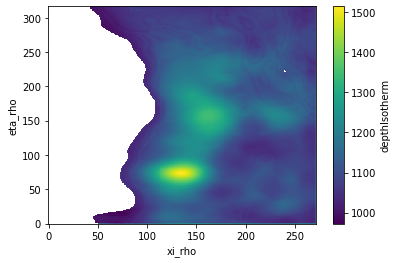

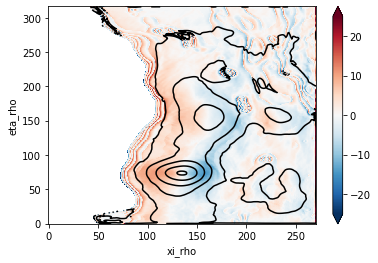

In [41]:
(-SSHSST_XBT_S.depthIsotherm).plot()
plt.show()
grid.diff(-SSHSST_XBT_S.depthIsotherm,'X',boundary='fill',fill_value=np.nan).plot(vmin=-25,vmax=25,cmap='RdBu_r')
(-SSHSST_XBT_S.depthIsotherm).plot.contour(colors='k')


Text(0.5, 0.96, 'Isotherm slope for 5$^\\circ$C')

<Figure size 432x288 with 0 Axes>

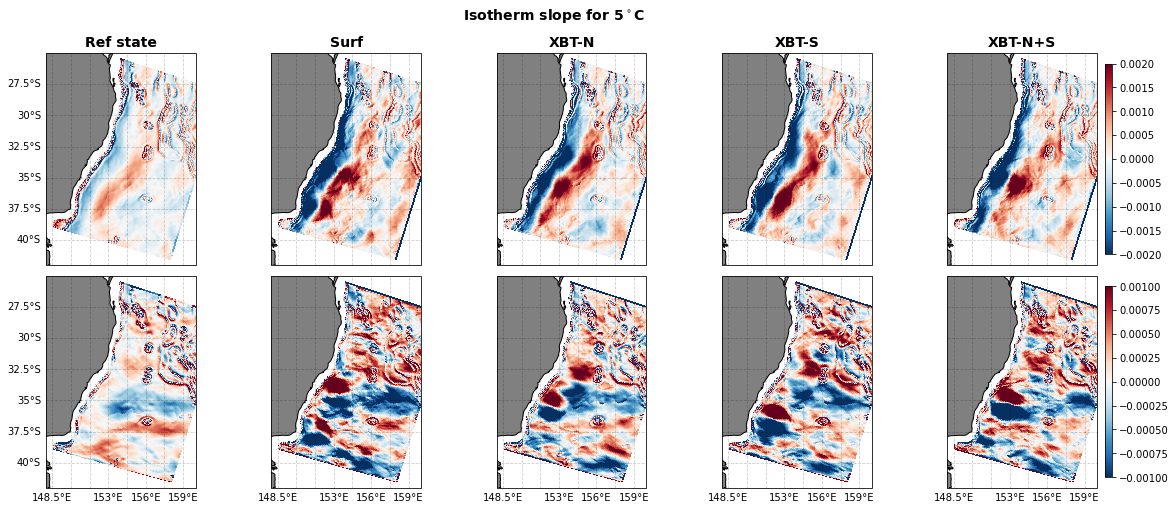

In [42]:


gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('+ve: sloping up offshore')


ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
# cbar.set_label('+ve: sloping up northwards')

fig.suptitle('Isotherm slope for '+str(isothermQueryValue)+'$^\circ$C',y=.96, fontsize=14, fontweight='bold',)

Text(0.5, 0.94, 'Isotherm slope for 5$^\\circ$C')

<Figure size 432x288 with 0 Axes>

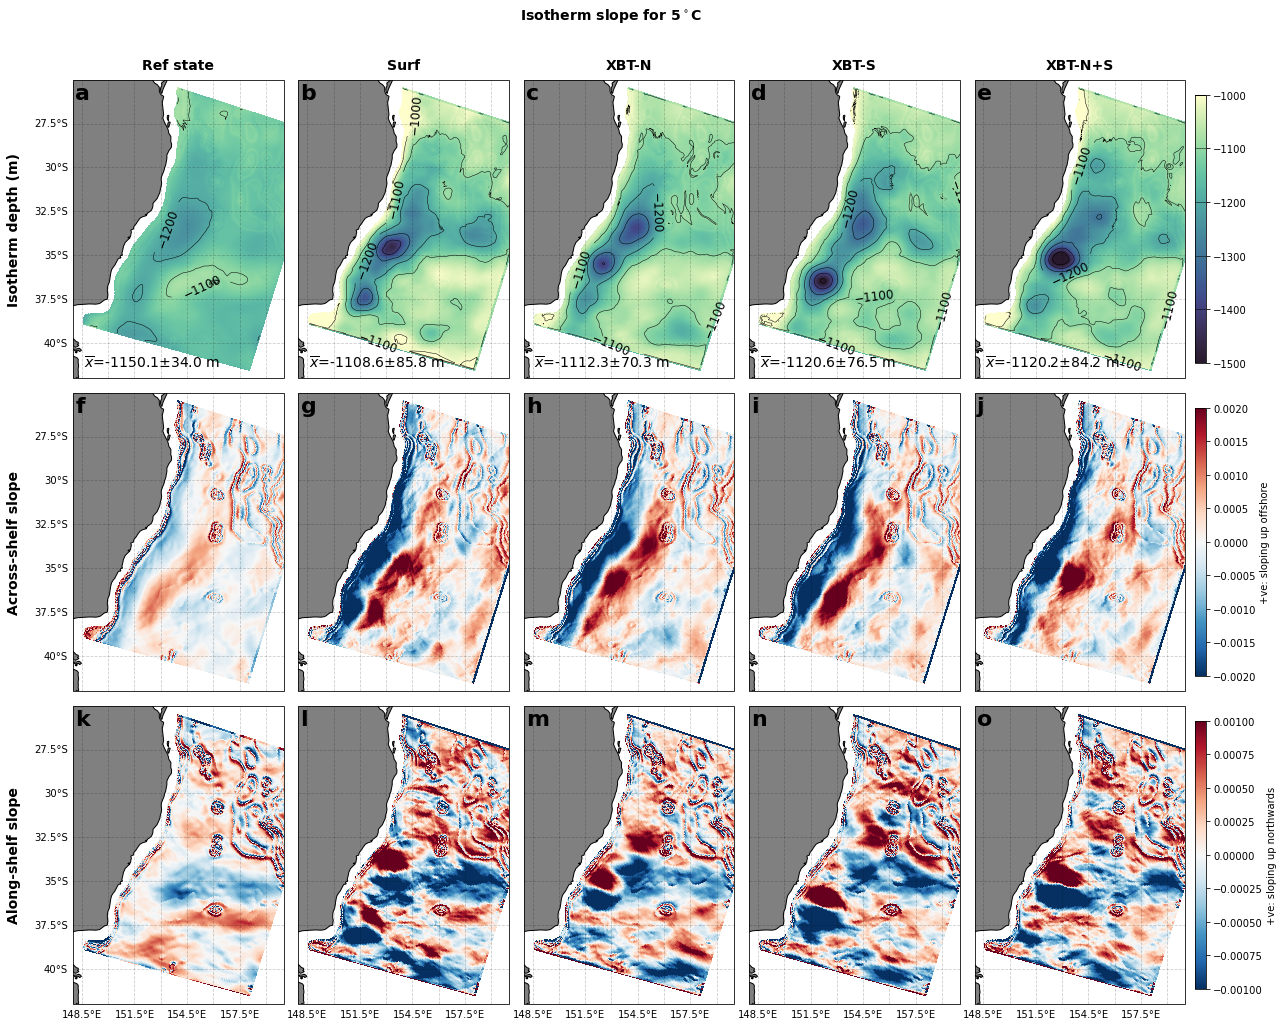

In [43]:

gs = gridspec.GridSpec(nrows=3,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,17])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.depthIsotherm.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.deep_r",vmin=-1500,vmax=-1000)
co=ax.contour(truth.lon_rho,truth.lat_rho,truth.depthIsotherm,colors='k',levels=np.arange(-1500,0,100),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(grid.average(truth.depthIsotherm,['X','Y']).round(decimals=1).values)+'$\pm$'+str(truth.depthIsotherm.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Isotherm depth (m)',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.depthIsotherm.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.deep_r",vmin=-1500,vmax=-1000)
co=ax.contour(SSHSST.lon_rho,SSHSST.lat_rho,SSHSST.depthIsotherm,colors='k',levels=np.arange(-1500,0,100),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(grid.average(SSHSST.depthIsotherm,['X','Y']).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthIsotherm.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.depthIsotherm.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.deep_r",vmin=-1500,vmax=-1000)
co=ax.contour(SSHSST_XBT_N.lon_rho,SSHSST_XBT_N.lat_rho,SSHSST_XBT_N.depthIsotherm,colors='k',levels=np.arange(-1500,0,100),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(grid.average(SSHSST_XBT_N.depthIsotherm,['X','Y']).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthIsotherm.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.depthIsotherm.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.deep_r",vmin=-1500,vmax=-1000)
co=ax.contour(SSHSST_XBT_S.lon_rho,SSHSST_XBT_S.lat_rho,SSHSST_XBT_S.depthIsotherm,colors='k',levels=np.arange(-1500,0,100),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(grid.average(SSHSST_XBT_S.depthIsotherm,['X','Y']).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthIsotherm.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.depthIsotherm.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="cmo.deep_r",vmin=-1500,vmax=-1000)
co=ax.contour(SSHSST_XBT.lon_rho,SSHSST_XBT.lat_rho,SSHSST_XBT.depthIsotherm,colors='k',levels=np.arange(-1500,0,100),linestyles='solid',linewidths=0.5)
ax.clabel(co, colors='k', fontsize=12)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.05, 0.05, ('$\overline{x}$='+str(grid.average(SSHSST_XBT.depthIsotherm,['X','Y']).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthIsotherm.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.add_lines(co)



ax = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)
ax.text(-.28, .5, 'Across-shelf slope',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[1,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.s_i_x.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.002,vmax=.002)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('+ve: sloping up offshore')



ax = fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truth.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.28, .5, 'Along-shelf slope',fontsize=14, fontweight='bold', va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax = fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.01, 0.99, 'l', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,2],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_N.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.01, 0.99, 'm', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,3],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT_S.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.01, 0.99, 'n', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,4],projection=ccrs.PlateCarree())
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = SSHSST_XBT.s_i_y.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap="RdBu_r",vmin=-.001,vmax=.001)
ax.set_extent([148, 160, -42, -25])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.text(0.01, 0.99, 'o', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="90%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.05,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('+ve: sloping up northwards')

fig.suptitle('Isotherm slope for '+str(isothermQueryValue)+'$^\circ$C',y=.94, fontsize=14, fontweight='bold',)

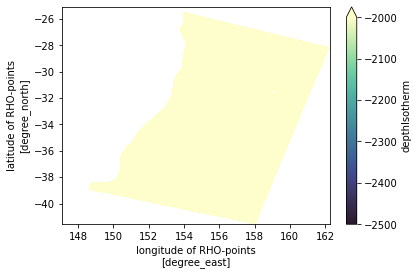

In [44]:
truth.depthIsotherm.plot(x='lon_rho',y='lat_rho',add_colorbar=True,cmap="cmo.deep_r",vmin=-2500,vmax=-2000)
plt.show()

In [45]:
truth.depthIsotherm.mean(dim=['eta_rho','xi_rho'])

<xarray.DataArray 'depthIsotherm' ()>
array(-1152.07990765)

In [46]:
calc_areaAverageROMS(truth.depthIsotherm,truth_bu)

<xarray.DataArray ()>
array(-889.07016491)

In [47]:
grid.average(truth.depthIsotherm,['X','Y']).values

array(-1150.12281568)

In [48]:
# # calculate the sharpest change in temp with depth (for each experiment)
# ## first calculate the grid coordinate where diff is maximised, then extract the z_w value where this occurs and only keep the top value
# truth["z_dtdzmax"] = truth.z_w0.where(truth.s_w3==(grid.diff(truth.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/truth.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST["z_dtdzmax"] = SSHSST.z_w0.where(SSHSST.s_w3==(grid.diff(SSHSST.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT["z_dtdzmax"] = SSHSST_XBT.z_w0.where(SSHSST_XBT.s_w3==(grid.diff(SSHSST_XBT.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT_N["z_dtdzmax"] = SSHSST_XBT_N.z_w0.where(SSHSST_XBT_N.s_w3==(grid.diff(SSHSST_XBT_N.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_N.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')
# SSHSST_XBT_S["z_dtdzmax"] = SSHSST_XBT_S.z_w0.where(SSHSST_XBT_S.s_w3==(grid.diff(SSHSST_XBT_S.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/SSHSST_XBT_S.dz_w0).idxmax(dim='s_w',skipna=True)).max(dim='s_w')


In [49]:
# import cartopy.io.img_tiles as cimgt
# stamen_terrain = cimgt.Stamen('terrain-background')

In [50]:


# gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[20,8])
# ax = None

# ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# truth.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# SSHSST.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# SSHSST_XBT_N.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# SSHSST_XBT_S.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# im=SSHSST_XBT.z_dtdzmax.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-100,vmax=0)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.z_dtdzmax,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.z_dtdzmax.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="90%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(1.05,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 

# fig.suptitle('Thermocline depth (max dT/dz)',y=.86, fontsize=14, fontweight='bold',)

In [51]:
# def calc_areaAverageROMS(input,grid):
#     output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
#     return output


In [52]:
# depth_DeepWater = -400 # deep water temperature 
# temp_offsetMLD = 0.8 # Kara et al., 2000,2003

# truth["tempDW"] = horizontalSectionROMS(grid, truth.temp, np.array([depth_DeepWater]))
# SSHSST["tempDW"] = horizontalSectionROMS(grid, SSHSST.temp, np.array([depth_DeepWater]))
# SSHSST_XBT_N["tempDW"] = horizontalSectionROMS(grid, SSHSST_XBT_N.temp, np.array([depth_DeepWater]))
# SSHSST_XBT_S["tempDW"] = horizontalSectionROMS(grid, SSHSST_XBT_S.temp, np.array([depth_DeepWater]))
# SSHSST_XBT["tempDW"] = horizontalSectionROMS(grid, SSHSST_XBT.temp, np.array([depth_DeepWater]))

# truth["temp0"] = truth.temp.isel(s_rho=-1)
# SSHSST["temp0"] = SSHSST.temp.isel(s_rho=-1)
# SSHSST_XBT_N["temp0"] = SSHSST_XBT_N.temp.isel(s_rho=-1)
# SSHSST_XBT_S["temp0"] = SSHSST_XBT_S.temp.isel(s_rho=-1)
# SSHSST_XBT["temp0"] = SSHSST_XBT.temp.isel(s_rho=-1)



# truth["tempMLD"] = truth.temp0 - temp_offsetMLD
# truth["tempTC"] = truth.tempMLD - 0.25*(truth.tempMLD-truth.temp400)

# SSHSST["tempMLD"] = SSHSST.temp0 - temp_offsetMLD
# SSHSST["tempTC"] = SSHSST.tempMLD - 0.25*(SSHSST.tempMLD-SSHSST.temp400)

# SSHSST_XBT_N["tempMLD"] = SSHSST_XBT_N.temp0 - temp_offsetMLD
# SSHSST_XBT_N["tempTC"] = SSHSST_XBT_N.tempMLD - 0.25*(SSHSST_XBT_N.tempMLD-SSHSST_XBT_N.temp400)

# SSHSST_XBT_S["tempMLD"] = SSHSST_XBT_S.temp0 - temp_offsetMLD
# SSHSST_XBT_S["tempTC"] = SSHSST_XBT_S.tempMLD - 0.25*(SSHSST_XBT_S.tempMLD-SSHSST_XBT_S.temp400)

# SSHSST_XBT["tempMLD"] = SSHSST_XBT.temp0 - temp_offsetMLD
# SSHSST_XBT["tempTC"] = SSHSST_XBT.tempMLD - 0.25*(SSHSST_XBT.tempMLD-SSHSST_XBT.temp400)

In [53]:
# truth.temp.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125)

In [54]:
# truth.tempTC.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125)



In [55]:
# from scipy import interpolate

# def calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims):
#     for xx in xxlims:
#         for ee in eelims:
#             ii = interpolate.interp1d(tempfield.isel(xi_rho=xx,eta_rho=ee),depthfield.isel(xi_rho=xx,eta_rho=ee))
#             depthTC[dict(eta_rho=ee,xi_rho=xx)] = ii(queryfield.isel(xi_rho=xx,eta_rho=ee))
#         if xx.values in np.round(np.linspace(0,len(xxlims.values),10)):
#             print(xx.values)
#     return depthTC


# depthTC = (truth.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = truth.temp.mean(dim='ocean_time').load()
# depthfield = truth.z_rho0.load()
# queryfield = truth.tempTC.mean(dim='ocean_time').load()
# xxlims = truth.xi_rho.load()
# eelims = truth.eta_rho.load()

# depthTC = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

# # tempfield = truth.temp.mean(dim='ocean_time').load()
# # depthfield = truth.z_rho0.load()
# # tempTCfield = truth.tempTC.mean(dim='ocean_time').load()

# # for xx in truth.xi_rho:
# #     for ee in truth.eta_rho:
# #         ii = interpolate.interp1d(tempfield.isel(xi_rho=xx,eta_rho=ee),depthfield.isel(xi_rho=xx,eta_rho=ee))
# #         depthTC[dict(eta_rho=ee,xi_rho=xx)] = ii(tempTCfield.isel(xi_rho=xx,eta_rho=ee))
# #     if xx.values in np.round(np.linspace(0,271,10)):
# #         print(xx.values)



In [56]:
# # interpolate for find depths of thermocline

# xxlims = truth.xi_rho.load()
# eelims = truth.eta_rho.load()

# #truth
# depthTC = (truth.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = truth.temp.mean(dim='ocean_time').load()
# depthfield = truth.z_rho0.load()
# queryfield = truth.tempTC.mean(dim='ocean_time').load()

# truth["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

# #SSHSST
# depthTC = (SSHSST.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = SSHSST.temp.mean(dim='ocean_time').load()
# depthfield = SSHSST.z_rho0.load()
# queryfield = SSHSST.tempTC.mean(dim='ocean_time').load()

# SSHSST["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

# #SSHSST_XBT_N
# depthTC = (SSHSST_XBT_N.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = SSHSST_XBT_N.temp.mean(dim='ocean_time').load()
# depthfield = SSHSST_XBT_N.z_rho0.load()
# queryfield = SSHSST_XBT_N.tempTC.mean(dim='ocean_time').load()

# SSHSST_XBT_N["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

# #SSHSST_XBT_S
# depthTC = (SSHSST_XBT_S.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = SSHSST_XBT_S.temp.mean(dim='ocean_time').load()
# depthfield = SSHSST_XBT_S.z_rho0.load()
# queryfield = SSHSST_XBT_S.tempTC.mean(dim='ocean_time').load()

# SSHSST_XBT_S["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

# #SSHSST_XBT
# depthTC = (SSHSST_XBT.tempTC.mean(dim='ocean_time')*np.nan).load()
# tempfield = SSHSST_XBT.temp.mean(dim='ocean_time').load()
# depthfield = SSHSST_XBT.z_rho0.load()
# queryfield = SSHSST_XBT.tempTC.mean(dim='ocean_time').load()

# SSHSST_XBT["depthTC"] = calc_depthToTempROMS(tempfield,depthfield,queryfield,xxlims,eelims)

In [57]:


# gs = gridspec.GridSpec(nrows=1,ncols=5,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[20,8])
# ax = None

# ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# truth.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# ax.text(0.5, 1.05, 'Ref state',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(truth.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(truth.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# SSHSST.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'Surf',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,2],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# SSHSST_XBT_N.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_N.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_N.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,3],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# SSHSST_XBT_S.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT_S.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT_S.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# ax = fig.add_subplot(gs[0,4],projection=ccrs.PlateCarree())
# ax.add_image(stamen_terrain, 4)
# ax.add_feature(Coast, edgecolor='black')
# im=SSHSST_XBT.depthTC.plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-150,vmax=-70)
# ax.set_extent([148, 160, -42, -25])
# gl = ax.gridlines(draw_labels=True,
#                     color='black', alpha=0.2, linestyle='--')
# gl.right_labels = False
# gl.top_labels = False
# gl.left_labels = False
# ax.text(0.5, 1.05, 'XBT-N+S',fontsize=14, fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.05, 0.05, ('$\overline{x}$='+str(calc_areaAverageROMS(SSHSST_XBT.depthTC,truth_bu).round(decimals=1).values)+'$\pm$'+str(SSHSST_XBT.depthTC.std().round(decimals=1).values)+' m') ,fontsize=14, va='center', ha='left', transform=ax.transAxes)

# cax = inset_axes(ax,
#                 width="5%",  # width = 10% of parent_bbox width
#                 height="90%",  # height : 50%
#                 loc='lower left',
#                 bbox_to_anchor=(1.05,.05, 1, 1),
#                 bbox_transform=ax.transAxes,
#                 borderpad=0,
#                 )
# cbar = fig.colorbar(im, cax=cax) 

# fig.suptitle('Thermocline depth ( z(T(MLD)-0.25(T(MLD)-T(400m)), T(MLD)=SST-0.8)',y=.86, fontsize=14, fontweight='bold')
# # fig.suptitle('                  (z(T(MLD)-0.25(T(MLD)-T(400m))))',y=.83, fontsize=14, fontweight='bold',)

In [58]:
# SSHSST_XBT.temp.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125).plot(y='z_rho0',marker='o')
# print(SSHSST_XBT.tempMLD.mean(dim='ocean_time').isel(xi_rho=140,eta_rho=125))
# plt.ylim(-400,0)